# Self-RAG

Self-reflection can enhance RAG, enabling correction of poor quality retrieval
or generations.

Several recent papers focus on this theme, but implementing the ideas can be
tricky.

Here we show how to implement ideas from the `Self RAG` paper
[here](https://arxiv.org/abs/2310.11511) using LangGraph.

## Dependencies

Set `OPENAI_API_KEY`

## Self-RAG Detail

Self-RAG is a recent paper that introduces an interesting approach for
self-reflective RAG.

The framework trains an LLM (e.g., LLaMA2-7b or 13b) to generate tokens that
govern the RAG process in a few ways:

1. Should I retrieve from retriever, `R` -

- Token: `Retrieve`
- Input: `x (question)` OR `x (question)`, `y (generation)`
- Decides when to retrieve `D` chunks with `R`
- Output: `yes, no, continue`

2. Are the retrieved passages `D` relevant to the question `x` -

- Token: `ISREL`
-
  - Input: (`x (question)`, `d (chunk)`) for `d` in `D`
- `d` provides useful information to solve `x`
- Output: `relevant, irrelevant`

3. Are the LLM generation from each chunk in `D` is relevant to the chunk
   (hallucinations, etc) -

- Token: `ISSUP`
- Input: `x (question)`, `d (chunk)`, `y (generation)` for `d` in `D`
- All of the verification-worthy statements in `y (generation)` are supported by
  `d`
- Output: `{fully supported, partially supported, no support`

4. The LLM generation from each chunk in `D` is a useful response to
   `x (question)` -

- Token: `ISUSE`
- Input: `x (question)`, `y (generation)` for `d` in `D`
- `y (generation)` is a useful response to `x (question)`.
- Output: `{5, 4, 3, 2, 1}`

We can represent this as a graph:

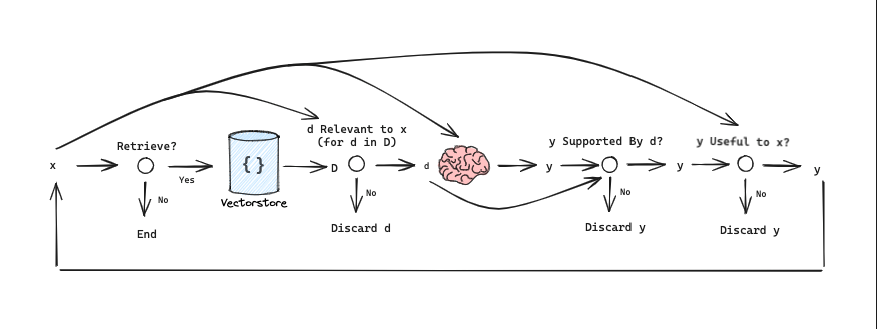

---

Let's implement some of these ideas from scratch using
[LangGraph](https://js.langchain.com/docs/langgraph).

## Setup

### Load env vars

Add a `.env` variable in the root of the repo folder with your variables.

In [1]:
import "dotenv/config";

### Install dependencies

```bash
npm install cheerio zod langchain @langchain/community @langchain/openai @langchain/core @langchain/textsplitters @langchain/langgraph
```

In [2]:
import { CheerioWebBaseLoader } from "@langchain/community/document_loaders/web/cheerio";
import { RecursiveCharacterTextSplitter } from "@langchain/textsplitters";
import { MemoryVectorStore } from "langchain/vectorstores/memory";
import { OpenAIEmbeddings } from "@langchain/openai";

const urls = [
  "https://lilianweng.github.io/posts/2023-06-23-agent/",
  "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
  "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
];

const docs = await Promise.all(
  urls.map((url) => new CheerioWebBaseLoader(url).load()),
);
const docsList = docs.flat();

const textSplitter = new RecursiveCharacterTextSplitter({
  chunkSize: 500,
  chunkOverlap: 250,
});
const docSplits = await textSplitter.splitDocuments(docsList);

// Add to vectorDB
const vectorStore = await MemoryVectorStore.fromDocuments(
  docSplits,
  new OpenAIEmbeddings({ model: "text-embedding-3-large" }),
);
const retriever = vectorStore.asRetriever();

## State

We will define a graph.

Our state will be an `object`.

We can access this from any graph node as `state.key`.

In [3]:
import { Annotation } from "@langchain/langgraph";
import { type DocumentInterface } from "@langchain/core/documents";

// Represents the state of our graph.
const GraphState = Annotation.Root({
  documents: Annotation<DocumentInterface[]>({
    reducer: (x, y) => y ?? x ?? [],
  }),
  question: Annotation<string>({
    reducer: (x, y) => y ?? x ?? "",
  }),
  generation: Annotation<string>({
    reducer: (x, y) => y ?? x,
    default: () => "",
  }),
  generationVQuestionGrade: Annotation<string>({
    reducer: (x, y) => y ?? x,
  }),
  generationVDocumentsGrade: Annotation<string>({
    reducer: (x, y) => y ?? x,
  }),
});

## Nodes and Edges

Each `node` will simply modify the `state`.

Each `edge` will choose which `node` to call next.

We can lay out `self-RAG` as a graph.

Here is our graph flow:

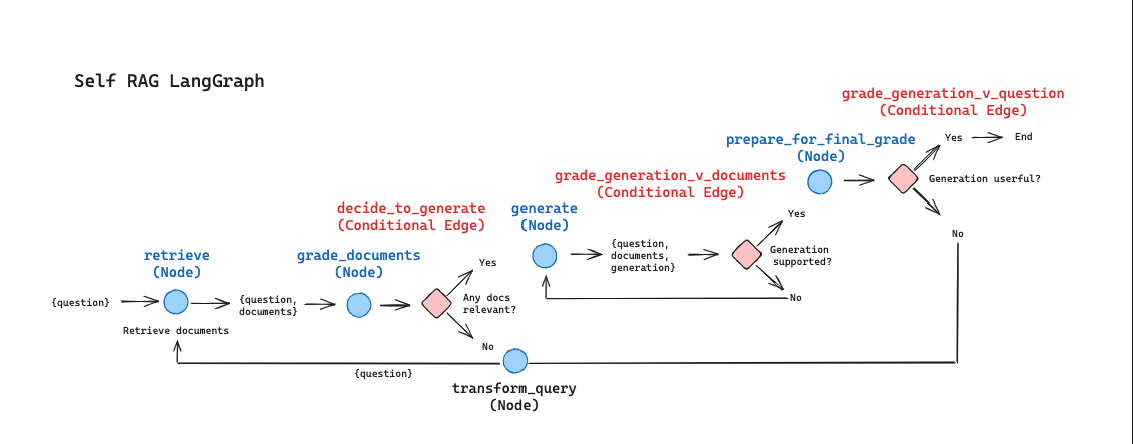

In [4]:
import { z } from "zod";
import { ChatPromptTemplate } from "@langchain/core/prompts";
import { pull } from "langchain/hub";
import { ChatOpenAI } from "@langchain/openai";
import { StringOutputParser } from "@langchain/core/output_parsers";
import type { RunnableConfig } from "@langchain/core/runnables";
import { formatDocumentsAsString } from "langchain/util/document";

// Define the LLM once. We'll reuse it throughout the graph.
const model = new ChatOpenAI({
  model: "gpt-4o",
  temperature: 0,
});

/**
 * Retrieve documents
 *
 * @param {typeof GraphState.State} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<Partial<typeof GraphState.State>>} The new state object.
 */
async function retrieve(
  state: typeof GraphState.State,
  config?: RunnableConfig
): Promise<Partial<typeof GraphState.State>> {
  console.log("---RETRIEVE---");

  const documents = await retriever
    .withConfig({ runName: "FetchRelevantDocuments" })
    .invoke(state.question, config);

  return {
    documents,
  };
}

/**
 * Generate answer
 *
 * @param {typeof GraphState.State} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<Partial<typeof GraphState.State>>} The new state object.
 */
async function generate(
  state: typeof GraphState.State
): Promise<Partial<typeof GraphState.State>> {
  console.log("---GENERATE---");

  // Pull in the prompt
  const prompt = await pull<ChatPromptTemplate>("rlm/rag-prompt");
  // Construct the RAG chain by piping the prompt, model, and output parser
  const ragChain = prompt.pipe(model).pipe(new StringOutputParser());

  const generation = await ragChain.invoke({
    context: formatDocumentsAsString(state.documents),
    question: state.question,
  });

  return {
    generation,
  };
}

/**
 * Determines whether the retrieved documents are relevant to the question.
 *
 * @param {typeof GraphState.State} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<Partial<typeof GraphState.State>>} The new state object.
 */
async function gradeDocuments(
  state: typeof GraphState.State
): Promise<Partial<typeof GraphState.State>> {
  console.log("---CHECK RELEVANCE---");

  // pass the name & schema to `withStructuredOutput` which will force the model to call this tool.
  const llmWithTool = model.withStructuredOutput(
    z
      .object({
        binaryScore: z
          .enum(["yes", "no"])
          .describe("Relevance score 'yes' or 'no'"),
      })
      .describe(
        "Grade the relevance of the retrieved documents to the question. Either 'yes' or 'no'."
      ),
    {
      name: "grade",
    }
  );

  const prompt = ChatPromptTemplate.fromTemplate(
    `You are a grader assessing relevance of a retrieved document to a user question.
  Here is the retrieved document:
  
  {context}
  
  Here is the user question: {question}

  If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant.
  Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.`
  );

  // Chain
  const chain = prompt.pipe(llmWithTool);

  const filteredDocs: Array<DocumentInterface> = [];
  for await (const doc of state.documents) {
    const grade = await chain.invoke({
      context: doc.pageContent,
      question: state.question,
    });
    if (grade.binaryScore === "yes") {
      console.log("---GRADE: DOCUMENT RELEVANT---");
      filteredDocs.push(doc);
    } else {
      console.log("---GRADE: DOCUMENT NOT RELEVANT---");
    }
  }

  return {
    documents: filteredDocs,
  };
}

/**
 * Transform the query to produce a better question.
 *
 * @param {typeof GraphState.State} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<Partial<typeof GraphState.State>>} The new state object.
 */
async function transformQuery(
  state: typeof GraphState.State
): Promise<Partial<typeof GraphState.State>> {
  console.log("---TRANSFORM QUERY---");

  // Pull in the prompt
  const prompt = ChatPromptTemplate.fromTemplate(
    `You are generating a question that is well optimized for semantic search retrieval.
  Look at the input and try to reason about the underlying sematic intent / meaning.
  Here is the initial question:
  \n ------- \n
  {question} 
  \n ------- \n
  Formulate an improved question: `
  );

  // Construct the chain
  const chain = prompt.pipe(model).pipe(new StringOutputParser());
  const betterQuestion = await chain.invoke({ question: state.question });

  return {
    question: betterQuestion,
  };
}

/**
 * Determines whether to generate an answer, or re-generate a question.
 *
 * @param {typeof GraphState.State} state The current state of the graph.
 * @returns {"transformQuery" | "generate"} Next node to call
 */
function decideToGenerate(state: typeof GraphState.State) {
  console.log("---DECIDE TO GENERATE---");

  const filteredDocs = state.documents;
  if (filteredDocs.length === 0) {
    // All documents have been filtered checkRelevance
    // We will re-generate a new query
    console.log("---DECISION: TRANSFORM QUERY---");
    return "transformQuery";
  }

  // We have relevant documents, so generate answer
  console.log("---DECISION: GENERATE---");
  return "generate";
}

/**
 * Determines whether the generation is grounded in the document.
 *
 * @param {typeof GraphState.State} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<Partial<typeof GraphState.State>>} The new state object.
 */
async function generateGenerationVDocumentsGrade(
  state: typeof GraphState.State
): Promise<Partial<typeof GraphState.State>> {
  console.log("---GENERATE GENERATION vs DOCUMENTS GRADE---");

  const llmWithTool = model.withStructuredOutput(
    z
      .object({
        binaryScore: z
          .enum(["yes", "no"])
          .describe("Relevance score 'yes' or 'no'"),
      })
      .describe(
        "Grade the relevance of the retrieved documents to the question. Either 'yes' or 'no'."
      ),
    {
      name: "grade",
    }
  );

  const prompt = ChatPromptTemplate.fromTemplate(
    `You are a grader assessing whether an answer is grounded in / supported by a set of facts.
  Here are the facts:
  \n ------- \n
  {documents} 
  \n ------- \n
  Here is the answer: {generation}
  Give a binary score 'yes' or 'no' to indicate whether the answer is grounded in / supported by a set of facts.`
  );

  const chain = prompt.pipe(llmWithTool);

  const score = await chain.invoke({
    documents: formatDocumentsAsString(state.documents),
    generation: state.generation,
  });

  return {
    generationVDocumentsGrade: score.binaryScore,
  };
}

function gradeGenerationVDocuments(state: typeof GraphState.State) {
  console.log("---GRADE GENERATION vs DOCUMENTS---");

  const grade = state.generationVDocumentsGrade;
  if (grade === "yes") {
    console.log("---DECISION: SUPPORTED, MOVE TO FINAL GRADE---");
    return "supported";
  }

  console.log("---DECISION: NOT SUPPORTED, GENERATE AGAIN---");
  return "not supported";
}

/**
 * Determines whether the generation addresses the question.
 *
 * @param {typeof GraphState.State} state The current state of the graph.
 * @param {RunnableConfig | undefined} config The configuration object for tracing.
 * @returns {Promise<Partial<typeof GraphState.State>>} The new state object.
 */
async function generateGenerationVQuestionGrade(
  state: typeof GraphState.State
): Promise<Partial<typeof GraphState.State>> {
  console.log("---GENERATE GENERATION vs QUESTION GRADE---");

  const llmWithTool = model.withStructuredOutput(
    z
      .object({
        binaryScore: z
          .enum(["yes", "no"])
          .describe("Relevance score 'yes' or 'no'"),
      })
      .describe(
        "Grade the relevance of the retrieved documents to the question. Either 'yes' or 'no'."
      ),
    {
      name: "grade",
    }
  );

  const prompt = ChatPromptTemplate.fromTemplate(
    `You are a grader assessing whether an answer is useful to resolve a question.
  Here is the answer:
  \n ------- \n
  {generation} 
  \n ------- \n
  Here is the question: {question}
  Give a binary score 'yes' or 'no' to indicate whether the answer is useful to resolve a question.`
  );

  const chain = prompt.pipe(llmWithTool);

  const score = await chain.invoke({
    question: state.question,
    generation: state.generation,
  });

  return {
    generationVQuestionGrade: score.binaryScore,
  };
}

function gradeGenerationVQuestion(state: typeof GraphState.State) {
  console.log("---GRADE GENERATION vs QUESTION---");

  const grade = state.generationVQuestionGrade;
  if (grade === "yes") {
    console.log("---DECISION: USEFUL---");
    return "useful";
  }

  console.log("---DECISION: NOT USEFUL---");
  return "not useful";
}


## Build Graph

The just follows the flow we outlined in the figure above.

In [5]:
import { END, START, StateGraph } from "@langchain/langgraph";

const workflow = new StateGraph(GraphState)
  // Define the nodes
  .addNode("retrieve", retrieve)
  .addNode("gradeDocuments", gradeDocuments)
  .addNode("generate", generate)
  .addNode(
    "generateGenerationVDocumentsGrade",
    generateGenerationVDocumentsGrade
  )
  .addNode("transformQuery", transformQuery)
  .addNode(
    "generateGenerationVQuestionGrade",
    generateGenerationVQuestionGrade
  );

// Build graph
workflow.addEdge(START, "retrieve");
workflow.addEdge("retrieve", "gradeDocuments");
workflow.addConditionalEdges("gradeDocuments", decideToGenerate, {
  transformQuery: "transformQuery",
  generate: "generate",
});
workflow.addEdge("transformQuery", "retrieve");
workflow.addEdge("generate", "generateGenerationVDocumentsGrade");
workflow.addConditionalEdges(
  "generateGenerationVDocumentsGrade",
  gradeGenerationVDocuments,
  {
    supported: "generateGenerationVQuestionGrade",
    "not supported": "generate",
  }
);

workflow.addConditionalEdges(
  "generateGenerationVQuestionGrade",
  gradeGenerationVQuestion,
  {
    useful: END,
    "not useful": "transformQuery",
  }
);

// Compile
const app = workflow.compile();

## Run the graph

In [6]:
const inputs = {
  question: "Explain how the different types of agent memory work.",
};
const config = { recursionLimit: 50 };

const prettifyOutput = (output: Record<string, any>) => {
  const key = Object.keys(output)[0];
  const value = output[key];
  console.log(`Node: '${key}'`);
  if (key === "retrieve" && "documents" in value) {
    console.log(`Retrieved ${value.documents.length} documents.`);
  } else if (key === "gradeDocuments" && "documents" in value) {
    console.log(`Graded documents. Found ${value.documents.length} relevant document(s).`);
  } else {
    console.dir(value, { depth: null });
  }
}

for await (const output of await app.stream(inputs, config)) {
  prettifyOutput(output);
  console.log("\n---ITERATION END---\n");
}

---RETRIEVE---
Node: 'retrieve'
Retrieved 4 documents.

---ITERATION END---

---CHECK RELEVANCE---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---DECIDE TO GENERATE---
---DECISION: GENERATE---
Node: 'gradeDocuments'
Graded documents. Found 3 relevant document(s).

---ITERATION END---

---GENERATE---
Node: 'generate'
{
  generation: 'Short-term memory in agents involves in-context learning, which is limited by the finite context window length of the model. Long-term memory allows the agent to retain and recall extensive information over extended periods by using an external vector store and fast retrieval mechanisms. Sensory memory involves learning embedding representations for raw inputs like text and images.'
}

---ITERATION END---

---GENERATE GENERATION vs DOCUMENTS GRADE---
---GRADE GENERATION vs DOCUMENTS---
---DECISION: SUPPORTED, MOVE TO FINAL GRADE---
Node: 'generateGenerationVDocumentsGrade'
{

> #### See the LangSmith trace [here](https://smith.langchain.com/public/cbf3c09a-5104-45f4-bd32-6e992e67f67a/r).